<a href="https://colab.research.google.com/github/zw2497/FlowerRecognition/blob/master/dl_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Recognition
Image Classification using a CNN on Flowers🌷

In this notebook, we will train a CNN-based image classifier to classify a couple thousand images of flowers, loaded from a directory on google drive.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download the [mini-flowers](https://storage.googleapis.com/applied-dl/mini_flowers.zip) dataset. 
This contains 1,500 images of five different types of flowers.

In [2]:
!wget https://storage.googleapis.com/applied-dl/mini_flowers.zip \
    -O /tmp/mini_flowers.zip

--2019-02-11 15:03:35--  https://storage.googleapis.com/applied-dl/mini_flowers.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40110537 (38M) [application/zip]
Saving to: ‘/tmp/mini_flowers.zip’

/tmp/mini_flowers.z 100%[===================>]  38.25M  36.6MB/s    in 1.0s    

2019-02-11 15:03:37 (36.6 MB/s) - ‘/tmp/mini_flowers.zip’ saved [40110537/40110537]



### unzip dataset

In [0]:
local_zip = '/tmp/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/mini_flowers')
zip_ref.close()

In [6]:
ls /tmp/mini_flowers

LICENSE.txt  train/  val/


In [0]:
base_dir = '/tmp/mini_flowers'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [14]:
os.listdir('/tmp/mini_flowers/train')

['dandelion', 'daisy', 'sunflowers', 'tulips', 'roses']

## Explore the data
Let's see how many image we have in each directory.

In [0]:
label_names = os.listdir('/tmp/mini_flowers/train')
label_train_dirs = [os.path.join(train_dir, i) for i in label_names]
label_val_dirs = [os.path.join(validation_dir, i) for i in label_names]

In [121]:
for label_name, label_train_dir, label_val_dir  in zip(label_names, label_train_dirs, label_val_dirs):
  print(label_name, '- Training:',len(os.listdir(label_dir)), '- Val: ',len(os.listdir(label_dir)))

dandelion - Training: 200 - Val:  200
daisy - Training: 200 - Val:  200
sunflowers - Training: 200 - Val:  200
tulips - Training: 200 - Val:  200
roses - Training: 200 - Val:  200


## Reading images off disk
We will use a couple handy utilities to read the images off disk, and to resize them to a consistent shape (and in the next notebook, to augment the training data). We will:

* Read the images from the disk
* Decode the JPGs into arrays of floating point values.
* Resize each image to be 150x150 pixels (our CNN requires all images to be the same shape).
* Rescale the pixel values from 0 and 255 to values between 0 and 1.

Fortunately, all these tasks can be done using a single class. Not only can it read images and preprocess them, but it will also set up generators that will turn these images into batches, which will be helpful when we train our network.

We can set up this using a couple of lines of code.

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 150 
BATCH_SIZE = 32

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [148]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, # Best practice: shuffle the training data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='sparse')
total_train = train_data_gen.n

Found 1000 images belonging to 5 classes.


In [149]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              class_mode='sparse')
total_val = val_data_gen.n

Found 500 images belonging to 5 classes.


Let's take a look at some of the images we've loaded. 

* The *next* function returns a batch from the dataset. 
* The return values are in the form of (images, labels). 

In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [152]:
sample_training_images[1].shape

(150, 150, 3)

In [153]:
sample_training_labels[5]

3.0

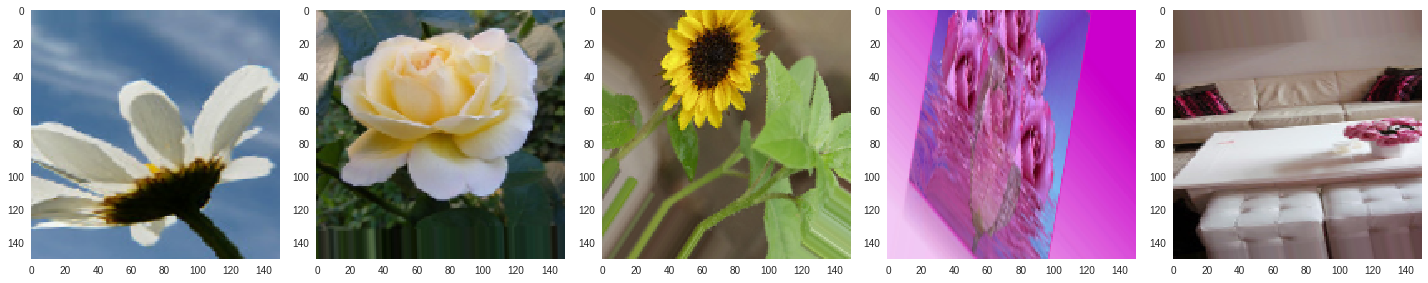

In [154]:
plotImages(sample_training_images[:5])

## Create and compile the model

In [0]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

In [156]:
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [157]:
EPOCHS = 50
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/50
10/10 [==============================] - 9s 855ms/step - loss: 1.6019 - acc: 0.2480 - val_loss: 1.4984 - val_acc: 0.3400
Epoch 2/50
10/10 [==============================] - 8s 819ms/step - loss: 1.3880 - acc: 0.3730 - val_loss: 1.1170 - val_acc: 0.5540
Epoch 3/50
10/10 [==============================] - 8s 824ms/step - loss: 1.1855 - acc: 0.4960 - val_loss: 1.2959 - val_acc: 0.5020
Epoch 4/50
10/10 [==============================] - 8s 819ms/step - loss: 1.0891 - acc: 0.5440 - val_loss: 1.2093 - val_acc: 0.5400
Epoch 5/50
10/10 [==============================] - 8s 828ms/step - loss: 1.0835 - acc: 0.5550 - val_loss: 1.0886 - val_acc: 0.5920
Epoch 6/50
10/10 [==============================] - 8s 817ms/step - loss: 1.0516 - acc: 0.5530 - val_loss: 1.2585 - val_acc: 0.5540
Epoch 7/50
10/10 [==============================] - 8s 823ms/step - loss: 1.0138 - acc: 0.5790 - val_loss: 1.4241 - val_acc: 0.5100
Epoch 8/50
10/10 [==============================] - 8s 814ms/step - loss: 0.

## Using CNN without data augmentation
* The model nearly overfitting at 5 epoch. 
* The avg accuracy is 63%

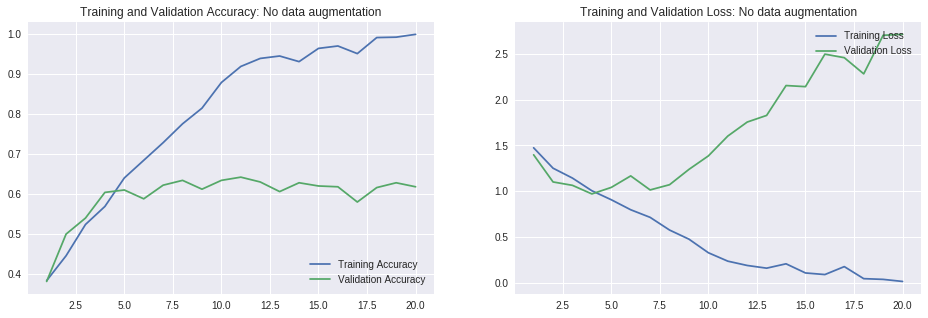

In [117]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: No data augmentation')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: No data augmentation')
plt.show()

## Using CNN with data augmentation
* The val accuracy improves to around 70%
* the loss function is much more bumping


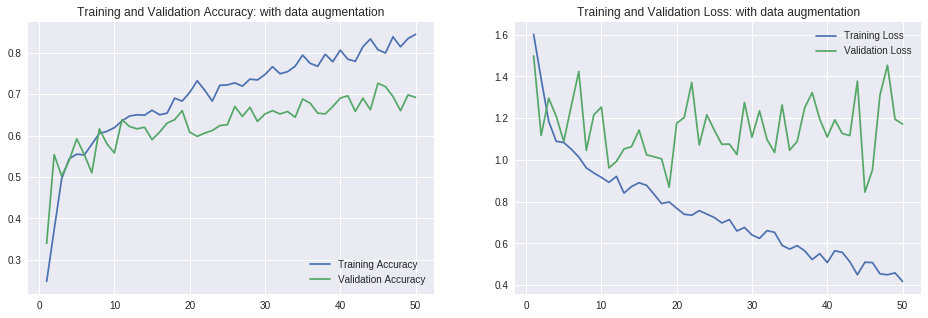

In [158]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: with data augmentation')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: with data augmentation')
plt.show()

## pretrain

In [0]:
from tensorflow.keras.applications import VGG16

In [161]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 5s 0us/step


In [162]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
model1 = Sequential([conv_base,Flatten(),Dense(512, activation='relu'), Dense(5, activation='softmax')])

In [164]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 2565      
Total params: 18,912,069
Trainable params: 18,912,069
Non-trainable params: 0
_________________________________________________________________


In [165]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='sparse')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='sparse')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [169]:
# Now is a good time for a cup of coffee
history = model1.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
5/5 [==============================] - 3s 537ms/step - loss: 1.0494 - acc: 0.6460
 - 16s - loss: 0.6017 - acc: 0.7620 - val_loss: 1.0494 - val_acc: 0.6460
Epoch 2/50
5/5 [==============================] - 3s 543ms/step - loss: 0.6869 - acc: 0.7400
 - 16s - loss: 0.5541 - acc: 0.7620 - val_loss: 0.6869 - val_acc: 0.7400
Epoch 3/50
5/5 [==============================] - 3s 540ms/step - loss: 0.7659 - acc: 0.6960
 - 16s - loss: 0.5239 - acc: 0.7990 - val_loss: 0.7659 - val_acc: 0.6960
Epoch 4/50
5/5 [==============================] - 3s 541ms/step - loss: 0.6844 - acc: 0.7300
 - 16s - loss: 0.5603 - acc: 0.7690 - val_loss: 0.6844 - val_acc: 0.7300
Epoch 5/50
5/5 [==============================] - 3s 542ms/step - loss: 1.0178 - acc: 0.6180
 - 16s - loss: 0.6007 - acc: 0.7380 - val_loss: 1.0178 - val_acc: 0.6180
Epoch 6/50
5/5 [==============================] - 3s 538ms/step - loss: 0.7775 - acc: 0.7040
 - 16s - loss: 0.6126 - acc: 0.7410 - val_loss: 0.7775 - val_acc: 0.7040
Epoc

## VGG + Dense 0-50 epoch
It's on the way. So I trained another 50 epoch

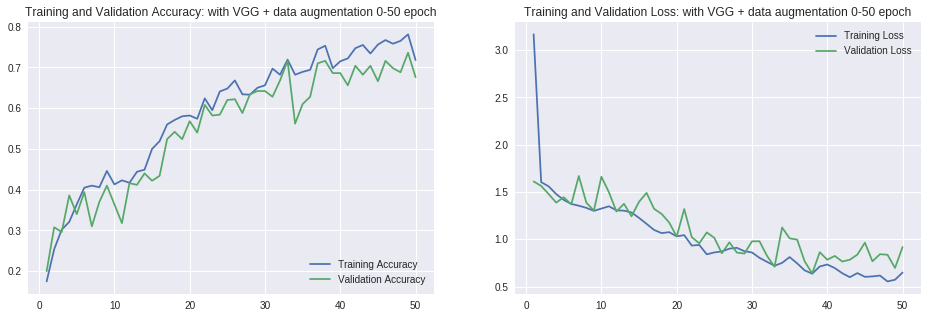

In [168]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: with VGG + data augmentation 0-50 epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: with VGG + data augmentation 0-50 epoch')
plt.show()

## VGG + Dence 50-100 Epoch
* accurary 76%

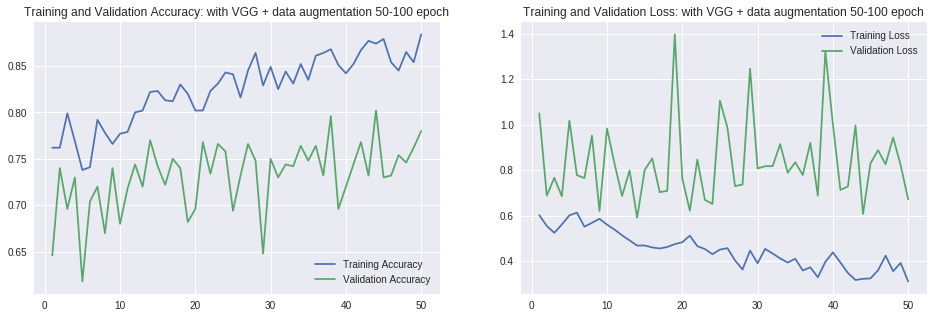

In [171]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: with VGG + data augmentation 50-100 epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: with VGG + data augmentation 50-100 epoch')
plt.show()

# ResNET50

In [0]:
from tensorflow.keras.applications import ResNet50

In [181]:
conv_res_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [188]:
model2 = Sequential([conv_res_base, Flatten(),Dense(2048, activation='relu'), Dense(512, activation='relu'), Dense(5, activation='softmax')])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv_res_base.trainable = False

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='sparse')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='sparse')
# Now is a good time for a cup of coffee

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [190]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_13 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 2565      
Total params: 49,805,189
Trainable params: 26,217,477
Non-trainable params: 23,587,712
_________________________________________________________________


In [200]:
history1 = model2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
16/16 [==============================] - 3s 158ms/step - loss: 1.7827 - acc: 0.6120
 - 11s - loss: 1.2777 - acc: 0.5700 - val_loss: 1.7827 - val_acc: 0.6120
Epoch 2/50
16/16 [==============================] - 3s 160ms/step - loss: 1.7622 - acc: 0.6160
 - 10s - loss: 1.2914 - acc: 0.5920 - val_loss: 1.7622 - val_acc: 0.6160
Epoch 3/50
16/16 [==============================] - 3s 161ms/step - loss: 1.7770 - acc: 0.6120
 - 10s - loss: 1.2187 - acc: 0.5970 - val_loss: 1.7770 - val_acc: 0.6120
Epoch 4/50
16/16 [==============================] - 3s 159ms/step - loss: 1.7858 - acc: 0.6060
 - 10s - loss: 1.2717 - acc: 0.5930 - val_loss: 1.7858 - val_acc: 0.6060
Epoch 5/50
16/16 [==============================] - 3s 159ms/step - loss: 1.7473 - acc: 0.6220
 - 10s - loss: 1.2952 - acc: 0.5690 - val_loss: 1.7473 - val_acc: 0.6220
Epoch 6/50
16/16 [==============================] - 3s 159ms/step - loss: 1.7649 - acc: 0.6080
 - 10s - loss: 1.1751 - acc: 0.6100 - val_loss: 1.7649 - val_acc:

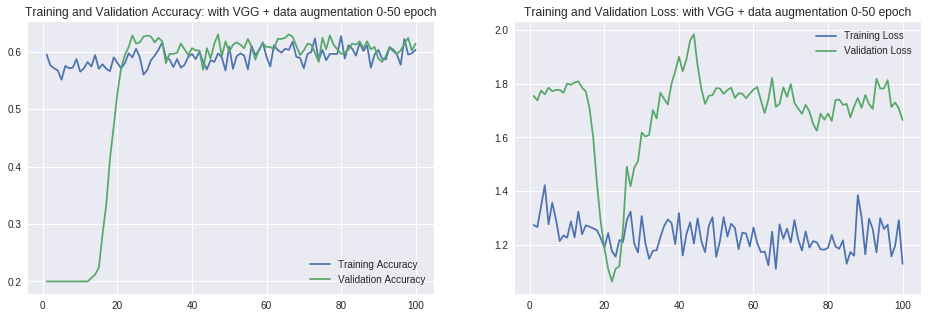

In [203]:
acc += history1.history['acc']
val_acc += history1.history['val_acc']

loss += history1.history['loss']
val_loss += history1.history['val_loss']

epochs_range = range(1, EPOCHS + 51)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: with VGG + data augmentation 0-50 epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: with VGG + data augmentation 0-50 epoch')
plt.show()